# LiDAR Virtual Lab, summer school in Lecce, 28-09-2023.

Welcome to today's workshop. Today, we will introduce how to generate geospatial data products of ecosystem structure from LiDAR using Notebook-as-a-VRE (NaaVRE) in LiDAR Vlab.

First, let's get some background of what is ecosystem structure and LiDAR data. 

## 1. What is ecosystem structure?

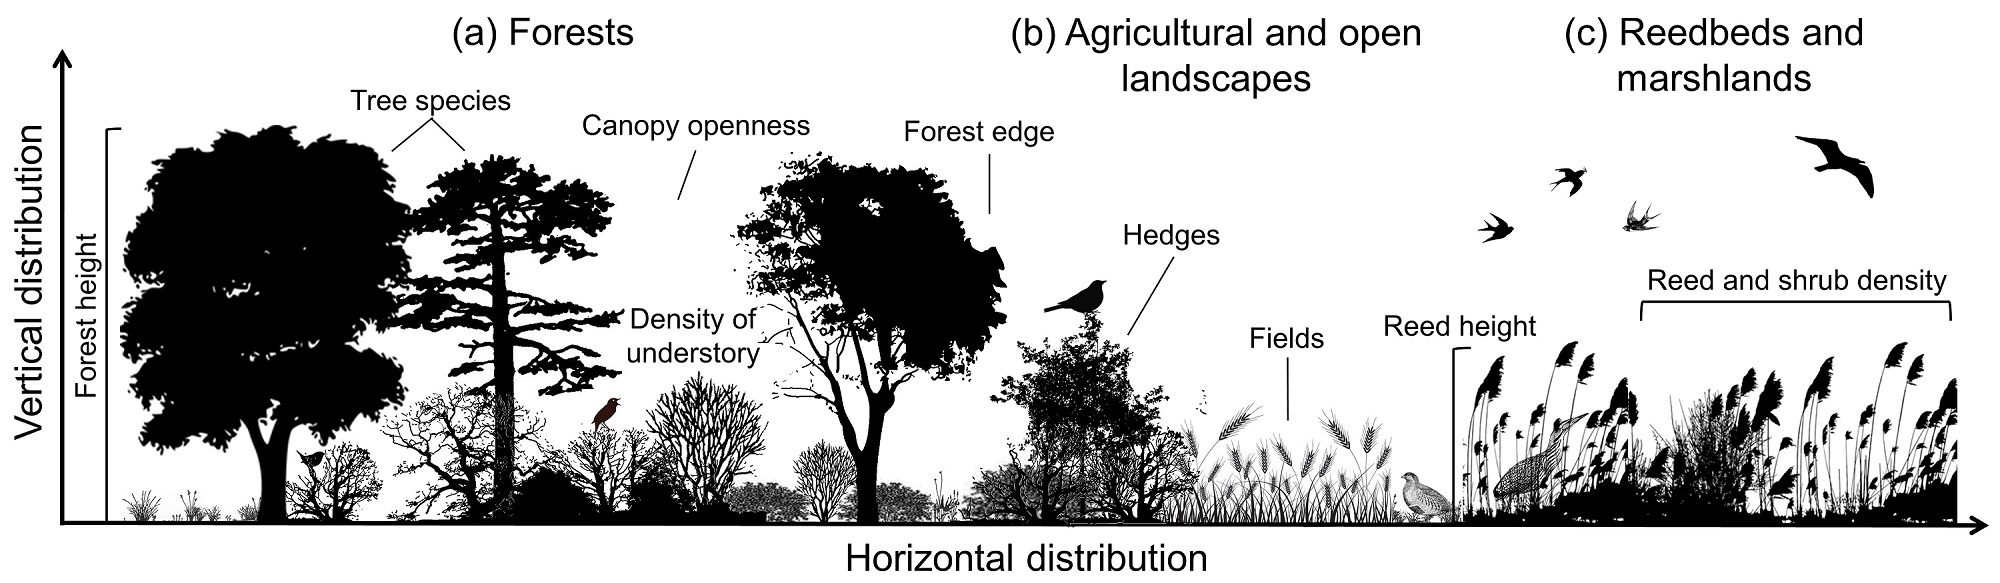

The vertical and horizontal distribution of plants influences habitat structure and 3D characteristics of vegetation for animals. Illustrated are examples for (a) forests, (b) agricultural and open landscapes, and (c) reedbeds and marshlands. The height, openness and density of vegetation as well as specific habitat features (e.g. tree species, hedges etc.) are key aspects of animal habitat and space use.

## 2. What is LiDAR?

LiDAR, or Light Detection And Ranging is one remote sensing method that can be used to map structure including vegetation height, density and other characteristics across a region. LiDAR directly measures the height and density of vegetation on the ground making it an ideal tool for scientists studying vegetation over large areas.

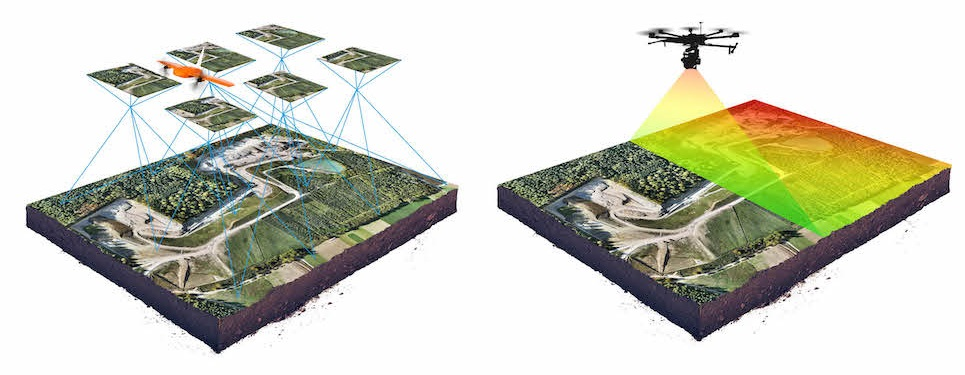

# 3. Laserfarm workflow
### A high-throughput workflow for quantifying ecosystem structure from airborne LiDAR

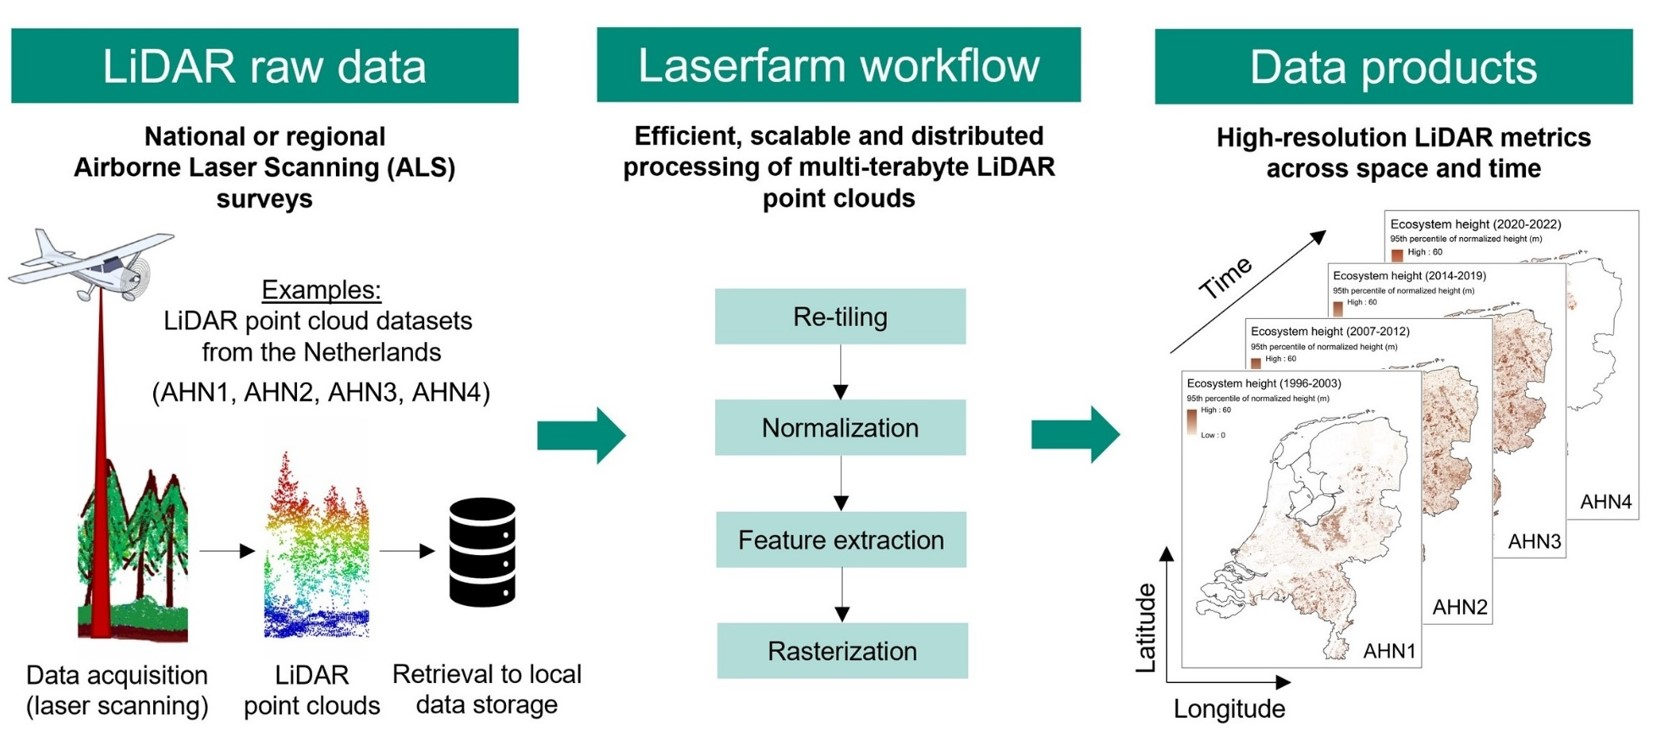

The Laserfarm workflow enables the efficient, scalable and distributed processing of multi-terabyte Light Detection And Ranging (LiDAR) point clouds from national and regional airborne laser scanning (ALS) surveys into raster layers of ecosystem structure. The Laserfarm workflow is exemplified with a country-wide LiDAR point cloud dataset from the Netherlands (AHN3).

## 3.1 Main steps of Laserfarm workflow

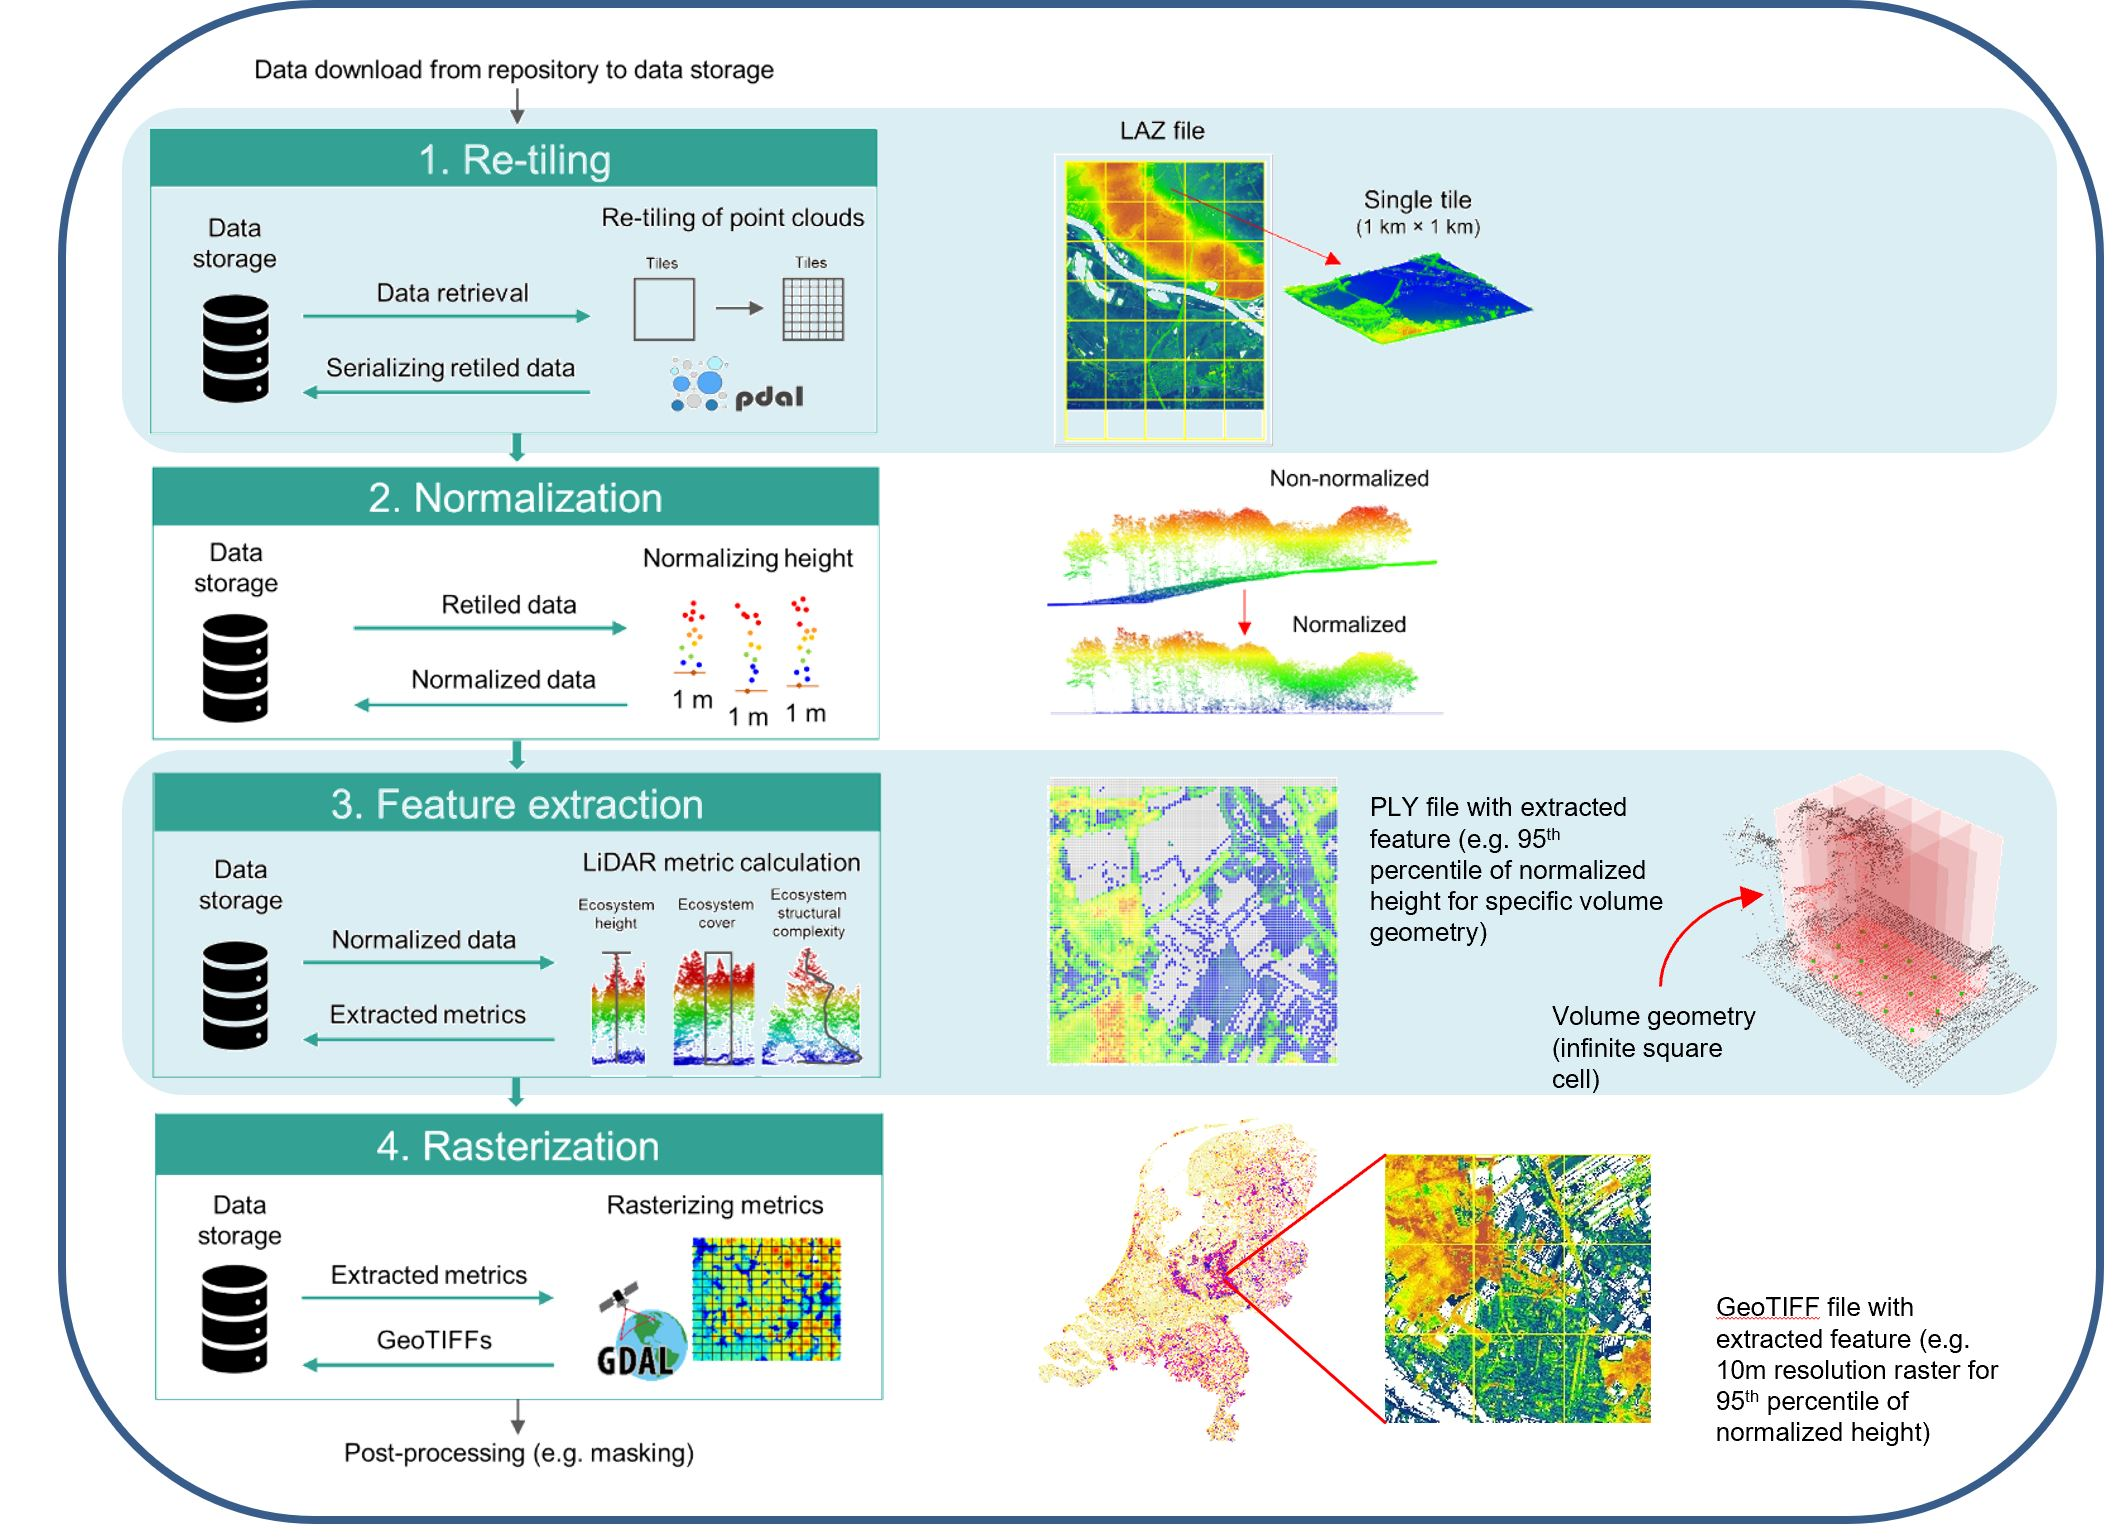

#### Each step can be containerized using NaaVRE and the workflow can be managed and executed within Jupyter environment.

Things can be modified within the workflow:

* Input data (point cloud from different area with various landscapes/ecosystems)

* The resolution of the final data products (how detail each pixel represents in the generated GeoTIFF layer)

* Define which feature(s) to be extracted for different applications (e.g. vegetation height, vegetation cover, vegetation density within a certain height range)


## 3.2 Explanation of the script used in the Laserfarm workflow

### (1) Set configurations

In [ ]:
# do not run
param_remote_path_root = pathlib.Path('/vl-laserfarm/')
conf_remote_path_split = pathlib.Path(param_remote_path_root + '/split')
conf_remote_path_retiled = pathlib.Path(param_remote_path_root + '/retiled/')
conf_remote_path_norm = pathlib.Path(param_remote_path_root + '/norm/')
conf_remote_path_targets = pathlib.Path(param_remote_path_root + '/targets')
conf_local_tmp = pathlib.Path('/tmp')
conf_remote_path_ahn = pathlib.Path(param_remote_path_root + '/anh')

param_hostname = 'https://lfw-ds001-i040.lifewatch.dev'
param_login = ''
param_password = ''

### (2) Modify parameters that generate different output

In [ ]:
## do not run
param_feature_name = 'perc_95_normalized_height'
param_validate_precision = '0.001'
param_tile_mesh_size = '10'
param_filter_type= 'select_equal'
param_attribute = 'raw_classification'
param_min_x = '-113107.81'
param_max_x = '398892.19'
param_min_y = '214783.87'
param_max_y = '726783.87'
param_n_tiles_side = '512'
param_apply_filter_value = '1'
param_laz_compression_factor = '7'
param_max_filesize = '262144000'

### (3) Fetching Laz Files from remote WebDAV

In [ ]:
## do not run
laz_files = [f for f in list_remote(get_wdclient(conf_wd_opts), conf_remote_path_ahn.as_posix())
             if f.lower().endswith('.laz')]

### (4) Split big files into small ones (optional)

### (5) Re-tiling

In [ ]:
# Retiling

from IPython.display import display, HTML   

remote_path_retiled = str(conf_remote_path_retiled)

grid_retile = {
    'min_x': float(param_min_x),
    'max_x': float(param_max_x),
    'min_y': float(param_min_y),
    'max_y': float(param_max_y),
    'n_tiles_side': int(param_n_tiles_side)
}


retiling_input = {
    'setup_local_fs': {'tmp_folder': conf_local_tmp.as_posix()},
    'pullremote': conf_remote_path_split.as_posix(),
    'set_grid': grid_retile,
    'split_and_redistribute': {},
    'validate': {},
    'pushremote': conf_remote_path_retiled.as_posix(),
    'cleanlocalfs': {}
}

    
file = split_laz_files
    
retiler = Retiler(file,label=file).config(retiling_input).setup_webdav_client(conf_wd_opts)
retiler_output = retiler.run()

### (6) Normalization

In [ ]:
# Fetch Tiles for Norm
remote_path_retiled

tiles = [t.strip('/') for t in list_remote(get_wdclient(conf_wd_opts), conf_remote_path_retiled.as_posix())
         if fnmatch.fnmatch(t, 'tile_*_*/')]

In [ ]:
# Normalization

import copy

tiles

remote_path_norm = str(conf_remote_path_norm)

normalization_input = {
    'setup_local_fs': {'tmp_folder': conf_local_tmp.as_posix()},
    'pullremote': conf_remote_path_retiled.as_posix(),
    'load': {'attributes': 'all'},
    # Filter out artifically high points - give overflow error when writing
    'apply_filter': {'filter_type':'select_below',
                     'attribute': 'z',
                     'threshold': 10000.},  # remove non-physically heigh points
    'normalize': 1,
    'clear_cache' : {},
    'pushremote': conf_remote_path_norm.as_posix(),
}

# write input dictionary to JSON file
with open('normalize.json', 'w') as f:
    json.dump(normalization_input, f)
    

# add pipeline list to macro-pipeline object and set the corresponding labels
tile = tiles
# for tile in tiles:
normalization_input_ = copy.deepcopy(normalization_input)
normalization_input_['export_point_cloud'] = {'filename': '{}.laz'.format(tile),'overwrite': True}
dp = DataProcessing(tile, label=tile).config(normalization_input_).setup_webdav_client(conf_wd_opts)
dp.run()

remote_path_norm


### (7) Feature extraction

In [ ]:
# Fetch Norm Tiles for feature
remote_path_norm

tiles = [t.strip('/') for t in list_remote(get_wdclient(conf_wd_opts), conf_remote_path_norm.as_posix())
         if fnmatch.fnmatch(t, 'tile_*_*/')]

In [ ]:
# Feature Extraction

t = tiles
    

features = [param_feature_name]

tile_mesh_size = float(param_tile_mesh_size)

grid_feature = {
    'min_x': float(param_min_x),
    'max_x': float(param_max_x),
    'min_y': float(param_min_y),
    'max_y': float(param_max_y),
    'n_tiles_side': int(param_n_tiles_side)
}

feature_extraction_input = {
    'setup_local_fs': {'tmp_folder': conf_local_tmp.as_posix()},
    'pullremote': conf_remote_path_retiled.as_posix(),
    'load': {'attributes': [param_attribute]},
    'normalize': 1,
    'apply_filter': {
        'filter_type': param_filter_type, 
        'attribute': param_attribute,
        'value': [int(param_apply_filter_value)]#ground surface (2), water (9), buildings (6), artificial objects (26), vegetation (?), and unclassified (1)
    },
    'generate_targets': {
        'tile_mesh_size' : tile_mesh_size,
        'validate' : True,
        'validate_precision': float(param_validate_precision),
        **grid_feature
    },
    'extract_features': {
        'feature_names': features,
        'volume_type': 'cell',
        'volume_size': tile_mesh_size
    },
    'export_targets': {
        'attributes': features,
        'multi_band_files': False
    },
    'pushremote': conf_remote_path_targets.as_posix(),
#     'cleanlocalfs': {}
}

    
    
    
idx = (t.split('_')[1:])
    
processing = DataProcessing(t, tile_index=idx,label=t).config(feature_extraction_input).setup_webdav_client(conf_wd_opts)
processing.run()

### (8) Rasterization

In [ ]:
# GeoTIFF Export

feature = features[0]

remote_path_geotiffs = conf_remote_path_ahn.parent / 'geotiffs'

# setup input dictionary to configure the GeoTIFF export pipeline
geotiff_export_input = {
    'setup_local_fs': {'tmp_folder': conf_local_tmp.as_posix()},
    'pullremote': conf_remote_path_targets.as_posix(),
    'parse_point_cloud': {},
    'data_split': {'xSub': 1, 'ySub': 1},
    'create_subregion_geotiffs': {'output_handle': 'geotiff'},
    'pushremote': remote_path_geotiffs.as_posix(),
    'cleanlocalfs': {}   
}

writer = GeotiffWriter(input_dir=param_feature_name, bands=param_feature_name,label=param_feature_name).config(geotiff_export_input).setup_webdav_client(conf_wd_opts)
writer.run()

# Exercise 

**The aim of this exercise is to 
(1) understand how Laserfarm workflow works, 
(2) to extract some LiDAR metrics for quantifying vegetation structure using NaaVRE, and 
(3) build your own workflow and explore the output.**

**We will use Laserfarm workflow (https://laserfarm.readthedocs.io/en/latest/) build on Laserchicken software (https://laserchicken.readthedocs.io/en/latest/) to process airborne laser scanning data. Check out this story map (https://storymaps.arcgis.com/stories/0c4aaf1d5c2645349897df701af6d051) to have an initial idea of what is LiDAR and how does it link with ecosystem structure.** 

**Log in LiDAR Vlab: https://school.lifewatchdev.eu/vreapp**

**Execution of the workflow: https://school.lifewatchdev.eu/argowf/workflows?limit=50**


**Sample data: .Laz files provided in the working directory  ../testdata/.laz**

**Sample workflow: ../Notebooks/Demo.ipynb**


In [ ]:
parameter settings:
# Set the root folder and the sub-folders for each step of the workflow
param_remote_path_root = pathlib.Path('/vl-laserfarm/')
conf_remote_path_split = pathlib.Path(param_remote_path_root + '/split')
conf_remote_path_retiled = pathlib.Path(param_remote_path_root + '/retiled/')
conf_remote_path_norm = pathlib.Path(param_remote_path_root + '/norm/')
conf_remote_path_targets = pathlib.Path(param_remote_path_root + '/targets')
conf_local_tmp = pathlib.Path('/tmp')
conf_remote_path_ahn = pathlib.Path(param_remote_path_root + '/ahn')

param_hostname = 'https://lfw-ds001-i040.lifewatch.dev/webdav'
param_login = ''
param_password = ''

### Parameters that can be modified in the workflow

`param_feature_name = 'perc_95_normalized_height' `

* feature_name defines the feature(s) you want to calculate, see https://laserchicken.readthedocs.io/en/latest/ for all the features you can calculate using Laserfarm workflow.

`param_validate_precision = '0.001'`

* validate_precision is set to avoid points falling on the edge of the tiles, you can keep as it is.

`param_tile_mesh_size = '10.'`

* tile_mesh_size defines the raster resolution for your final output (GeoTIFF layers)

`param_filter_type= 'select_equal'`


* filter_type selects the points you want to consider in the calculation, you can keep as it is.

`param_attribute = 'raw_classification'`

* attribute defines what attribute of each point you want to select for further calculation, you can keep as it is.



``param_min_x = '-113107.81'``

``param_max_x = '398892.19'``

``param_min_y = '214783.87'``

``param_max_y = '726783.87'``

``param_n_tiles_side = '512'``


* The grid that covers the area your LiDAR point cloud data. This is already pre-defined for the Netherlands, so you can leave as it is.

`param_apply_filter_value = '1'`

* apply_filter_value selects the points with specific attributes value, here 1 means classification code 1, representing vegetation points in the point cloud.


`param_laz_compression_factor = '7'`

`param_max_filesize = '262144000'  # desired max file size (in bytes)`


* laz_compression_factor and max_filesize only use for large files that need to be split into smaller files for computational efficiency (demanded memory, etc).



### Questions

### 1. What is the type of each parameter?

### 2. Can you containerize your own components and run the workflow? 

### 3. If I want to calculate LiDAR metrics at 5 meter resolution, which parameter should I modify?

### 4. If I want to know where the tallest tree is in my data, which feature name should I define?